In [16]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

In [6]:
url = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch10/housing.data.txt'
file_name = 'wk02_housing.txt'

req = requests.get(url)
url_content = req.content
csv_file = open(file_name, 'wb')
csv_file.write(url_content)
csv_file.close()

In [14]:
df = pd.read_csv(file_name, header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


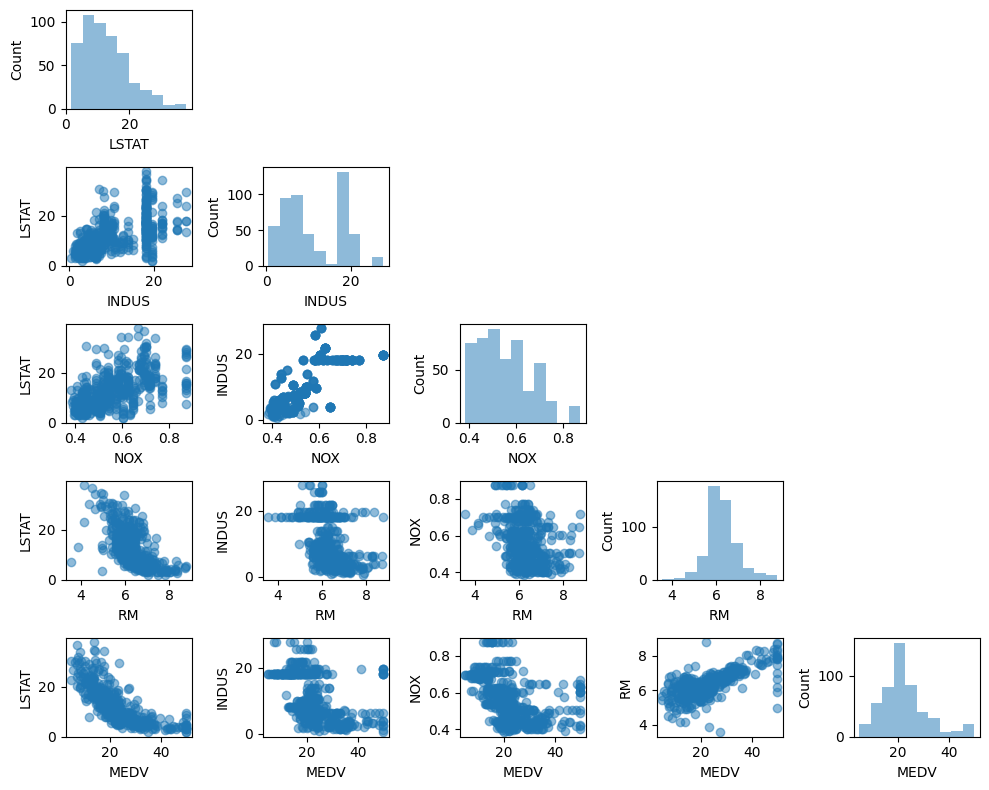

In [15]:
# RM pg 320
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

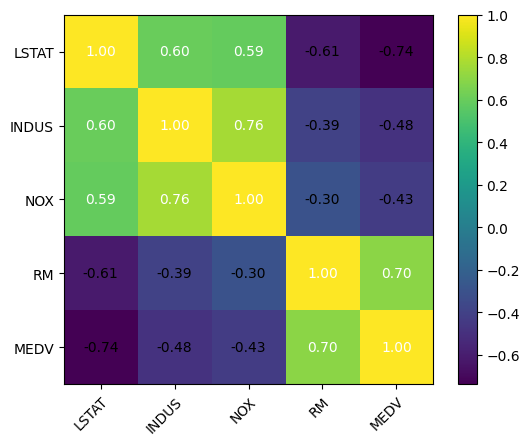

In [17]:
# RM pg 324
from mlxtend.plotting import heatmap

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

plt.show()

In [18]:
class LinearRegressionGD(object):
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [23]:
from sklearn.preprocessing import StandardScaler

X = df[['RM']].values
y = df['MEDV'].values

sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

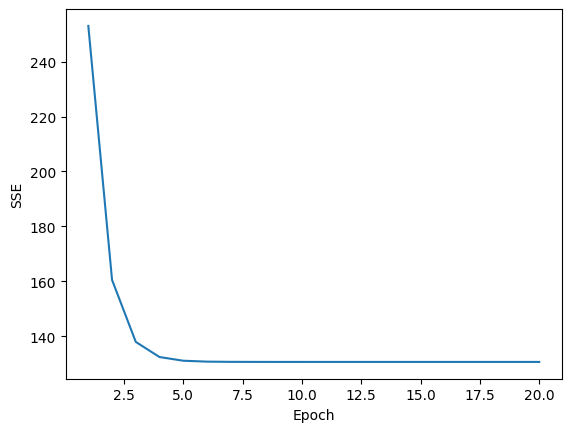

In [30]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

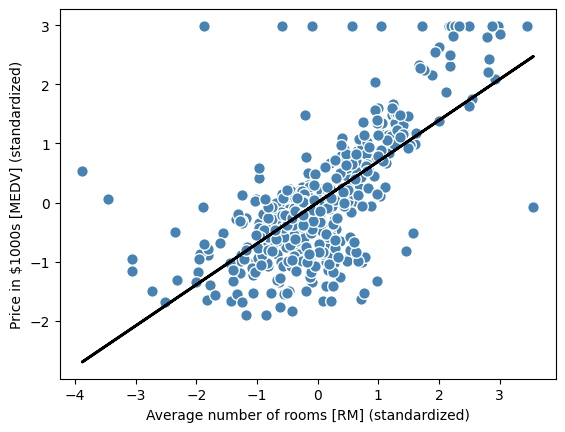

In [32]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [33]:
# Using scikit-learn to do the regression
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


In [35]:
# RM pg 332, using RANSAC

from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=50,
                         loss='absolute_error',
                         residual_threshold=5.0,
                         random_state=0)
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50, random_state=0,
                residual_threshold=5.0)

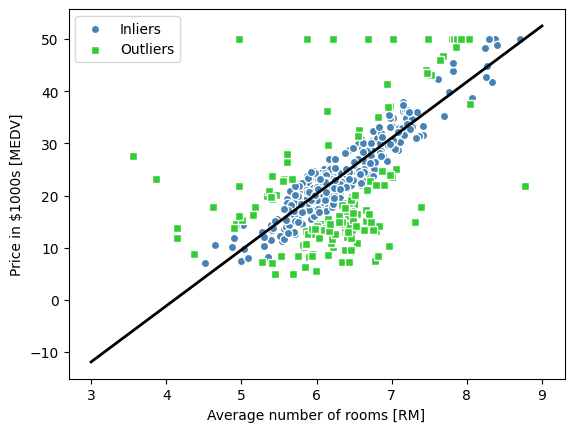

In [39]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
           c='steelblue', edgecolor='white',
           marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c='limegreen', edgecolor='white',
           marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [40]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [41]:
# RM pg 334, evaluate performance

from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

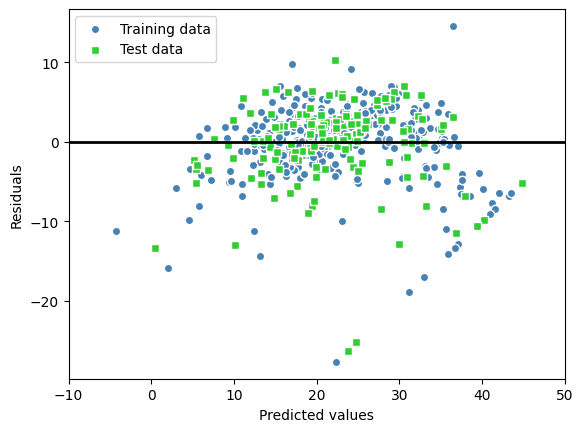

In [43]:
plt.scatter(y_train_pred, y_train_pred - y_train,
           c='steelblue', marker='o', edgecolor='white',
           label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='limegreen', marker='s', edgecolor='white',
           label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)
))

MSE train: 19.958, test: 27.196


In [46]:
from sklearn.metrics import r2_score

print('R^2 train: %.3f, R^2 test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)
))

R^2 train: 0.765, R^2 test: 0.673


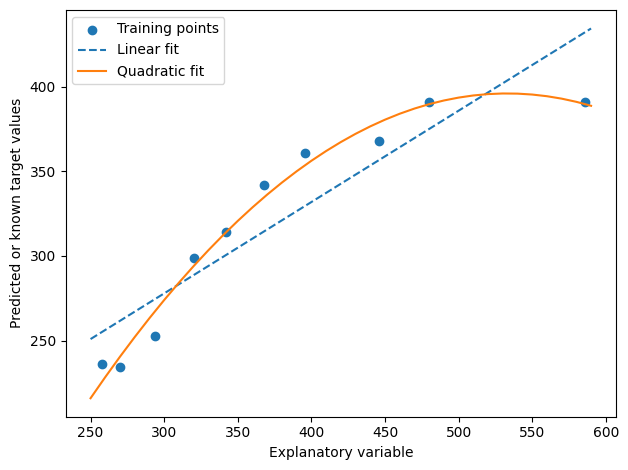

In [50]:
#RM pg 340, polynomial terms
from sklearn.preprocessing import PolynomialFeatures

# Add a 2nd degree polynomial term
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0,
             368.0, 396.0, 446.0, 480.0, 586.0]) \
            [:, np.newaxis]
y =np.array([236.4, 234.4, 252.8, 298.6, 314.2,
            342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# fit a simple lienar regression model for comparison
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# Fit a multiple regression model on the transformed ffeatures for polynomial regression
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# Plot the results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [53]:
y_lin_fit

array([250.86164718, 256.26469105, 261.66773493, 267.0707788 ,
       272.47382268, 277.87686655, 283.27991043, 288.6829543 ,
       294.08599818, 299.48904205, 304.89208593, 310.2951298 ,
       315.69817368, 321.10121755, 326.50426142, 331.9073053 ,
       337.31034917, 342.71339305, 348.11643692, 353.5194808 ,
       358.92252467, 364.32556855, 369.72861242, 375.1316563 ,
       380.53470017, 385.93774405, 391.34078792, 396.7438318 ,
       402.14687567, 407.54991955, 412.95296342, 418.3560073 ,
       423.75905117, 429.16209505, 434.56513892])

In [51]:
# get MSE and R^2
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
    mean_squared_error(y, y_lin_pred),
    mean_squared_error(y, y_quad_pred)
))

print('Training R^2 linear: %.3f, quadratic: %.3f' % (
    r2_score(y, y_lin_pred),
    r2_score(y, y_quad_pred)
))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


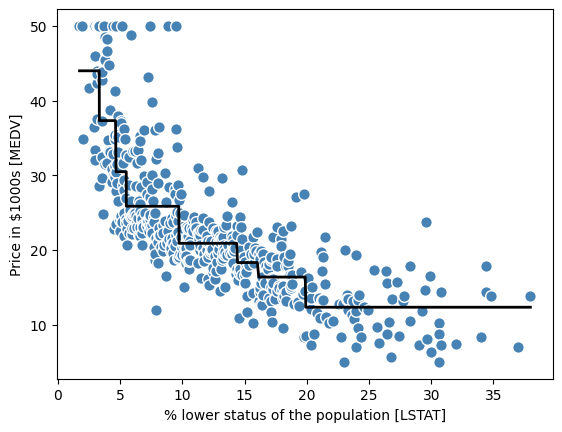

In [54]:
# RM pg 346, random forest
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [58]:
from sklearn.ensemble import RandomForestRegressor

X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='friedman_mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)
))

print('R^2 train: %.3f, test: %.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)
))

MSE train: 1.642, test: 11.050
R^2 train: 0.979, test: 0.878


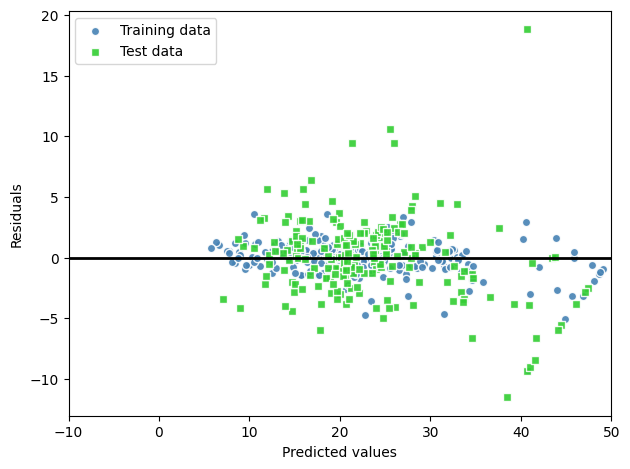

In [59]:
plt.scatter(y_train_pred, y_train_pred - y_train,
           c='steelblue', marker='o', edgecolor='white',
            s=35, alpha=0.9,
           label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
           c='limegreen', marker='s', edgecolor='white',
            s=35, alpha=0.9,
           label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()